In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import IPython
import sklearn
import mglearn

In [3]:
'''
單純貝氏分類器
(Naive Bayes Classifiers)
'''
X = np.array([[0, 1, 0, 1],
             [1, 0, 1, 1],
             [0, 0, 0, 1], 
             [1, 0, 1, 0]])
y = np.array([0, 1, 0, 1])

In [4]:
counts = {}
for label in np.unique(y):
    # 歷遍每一個類別
    # 計算每ㄧ特徵的數量
    counts[label] = X[y == label].sum(axis=0)
print("Feature counts:\n{}".format(counts))

Feature counts:
{0: array([0, 1, 0, 2]), 1: array([2, 0, 2, 1])}


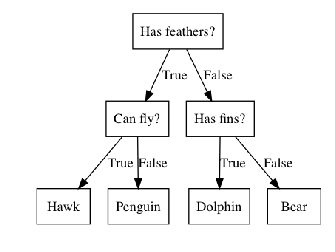

In [11]:
'''
決策樹 (Decision tree)
'''
mglearn.plots.plot_animal_tree()
plt.show()

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# breast cancer case
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


In [18]:
# max_depth=4
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

# 訓練集的準確度下降，但是測試集的準確度上升
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


In [29]:
'''
分析決策樹
'''
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "nbenigh"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

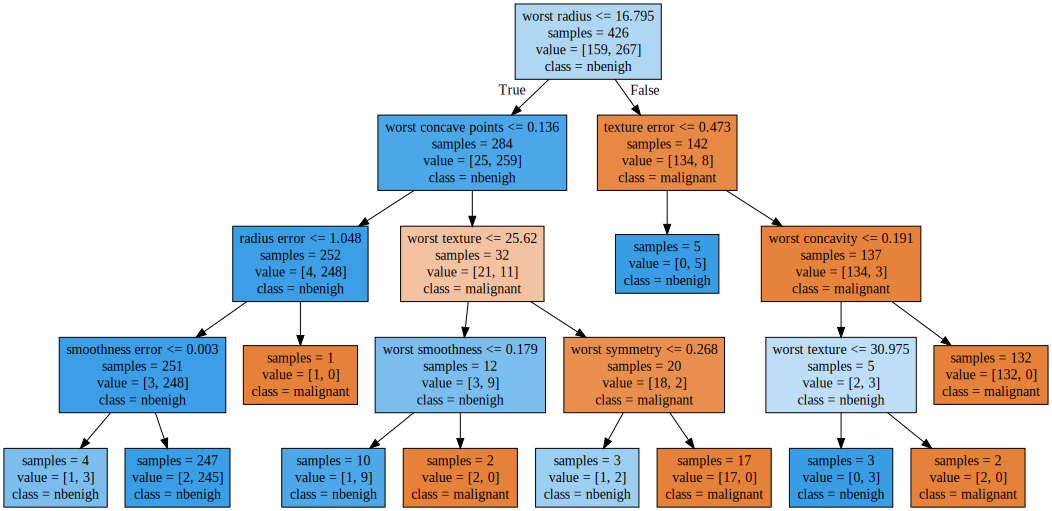

In [32]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [37]:
# 樹的特徵重要性，總和等於1
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01019737  0.04839825  0.          0.
  0.0024156   0.          0.          0.          0.          0.
  0.72682851  0.0458159   0.          0.          0.0141577   0.          0.018188
  0.1221132   0.01188548  0.        ]


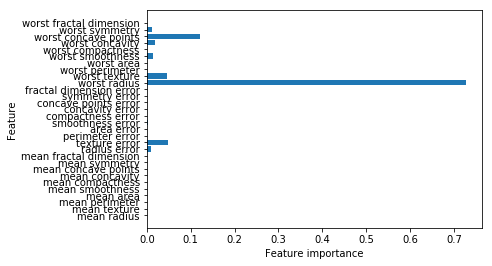

In [45]:
# 視覺化圖
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(tree)
plt.show()

Feature importances: [ 0.  1.]


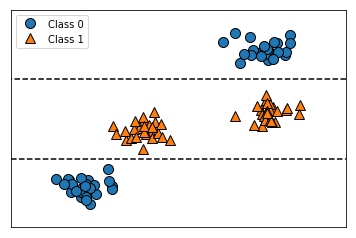

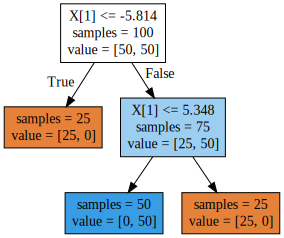

In [48]:
# 特徵和類別並沒有簡單的關係
tree = mglearn.plots.plot_tree_not_monotone()
plt.show()
display(tree)

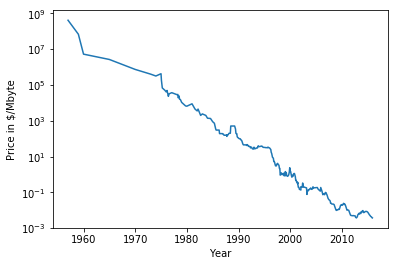

In [54]:
# 電腦記憶體(RAM)的歷史資料集
import pandas as pd
ram_prices = pd.read_csv("/anaconda3/lib/python3.6/site-packages/mglearn/data/ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")
plt.show()

In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# 用歷史資料預測 2000年後的價錢
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 基於日期預測價錢
X_train = data_train.date[:, np.newaxis]
# 用對數轉換得到一個簡化的資料和目標關係
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 預測所有資料
X_all = ram_prices.date[:,np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# 撤銷指數轉換
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

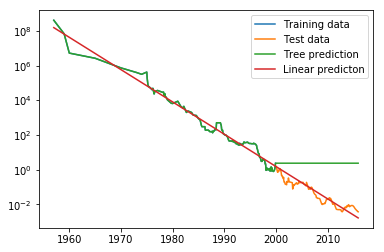

In [60]:
# 記憶體價格資料用線性模型所做的預測和迴歸樹的預測比較圖
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear predicton")
plt.legend()
plt.show()

In [61]:
'''
隨機森林 (Random forests)
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

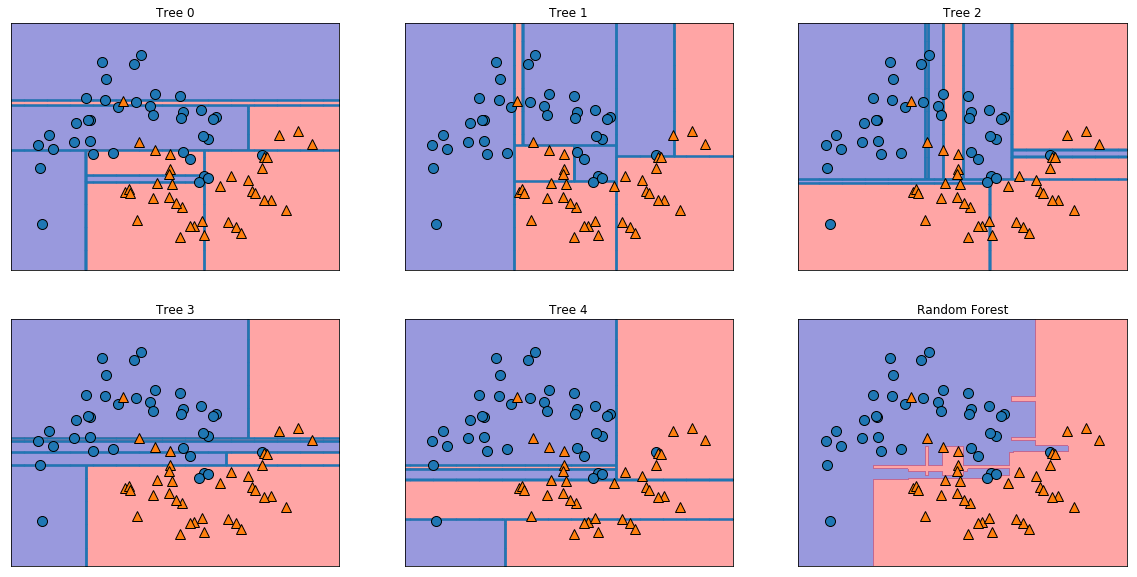

In [67]:
# 五個隨機決策樹由預測機率值的平均所獲得的判別邊界
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                               alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.show()

In [68]:
# 包含 100 棵樹在隨機森林的乳癌資料集
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


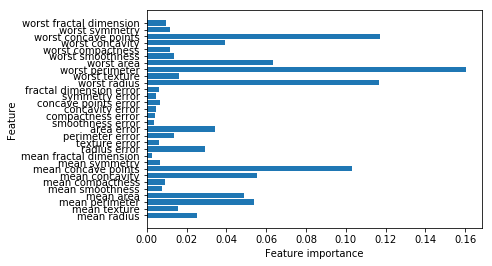

In [69]:
# 符合乳癌資料集的隨機森林所計算出的特徵重要性
plot_feature_importances_cancer(forest)
plt.show()

In [70]:
'''
梯度提升迴歸決策樹
(Gradient boosting machines)
'''
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))  # overfitting
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958


In [71]:
# 修改為限制最大深度來加強
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [77]:
# 或是降低學習率來加強
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


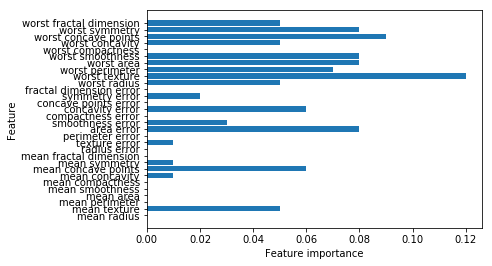

In [80]:
# 梯度提升分類器符合乳癌資料集所計算出的特徵重要性
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)
plt.show()